In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install ml-collections

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.9 MB/s eta 0:00:00


In [3]:
%cd "/content/drive/MyDrive/FYP/TCT code/vit-visual-search/notebooks"

# _________ APPEND SOME PATH TO IMPORT SOME LIBRARY BELOW _____________
import sys

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../irl_dcb')
sys.path.append('../../irl_dcb/irl_dcb')

# _________ APPEND SOME PATH TO IMPORT SOME LIBRARY BELOW _____________

/content/drive/MyDrive/FYP/TCT code/vit-visual-search/notebooks


In [4]:
import os

if os.path.exists('/src'):
    os.unlink('/src')
os.symlink(os.path.abspath('../..'), '/src')

Global variables for all datasets

In [5]:
cdf_dict = {}

# SEAGRAM

## Environment variable setup and library import

In [6]:
import json
import numpy as np
import torch
from os.path import join
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sns
from itertools import product
from PIL import Image
# import cv2
from tqdm import tqdm
import pickle

import dataset

# OLD visual_search
# from tasks.visual_search import add_init_fix, search_task, get_attn, load_model

# NEW visual_search
from tasks.visual_search1 import add_init_fix, search_task, get_attn, get_cdf, load_model



# from tasks.visual_search import *
from irl_dcb.utils import *


from torchvision import transforms
from data.SCEGRAM import scegram

In [7]:

device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  # macbook uses metal performance shaders to GPU accelearation
    if torch.backends.mps.is_available()
    else "cpu"
)



search_w = 512
search_h = 320
target_min = 128
patch_w = 16
patch_h = 16
n_patch_w, n_patch_h = int(search_w // patch_w), int(search_h // patch_h)
IOR_size = 24
dataset = 'scegram' #'natural-design', 'scegram'
n_random = 100



if dataset == 'coco18':
    # MIX4: ZR+RR+RZ+ZZ with the fixed search/target pairs
    with open('/src/vit-visual-search/CRT_coco18test_modelmix4ZR_original_1008.pkl', 'rb') as handle:
        crt_attn = pickle.load(handle)
    test_traj = json.load(open('/src/coco-search18_dataset/processed/coco_search18_fixations_TP_test.json'))
    tasks = np.unique(pd.DataFrame(test_traj)['task'].values)

elif dataset == 'natural-design':
    with open('/src/vit-visual-search/CRT_naturaldesign_modelmix4ZR_original_1008.pkl', 'rb') as handle:
        crt_attn = pickle.load(handle)

elif dataset == 'scegram':

    # _______________ PREVIOUS CODE __________________
    # with open('/src/vit-visual-search/CRT_SCEGRAM_modelmix4ZR_original_1008.pkl', 'rb') as handle:
    #     crt_attn = pickle.load(handle)
    # _______________ PREVIOUS CODE __________________


    # ______________ FIXED CODE__________________
    with open('/src/vit-visual-search/context/CRT_SCEGRAM_modelmix4ZR_original_1008.pkl', 'rb') as handle:
        crt_attn = pickle.load(handle)
    # ______________ FIXED CODE__________________

In [8]:
print('One CRT attention map size:', crt_attn['Scene62_SYN.png'].size())

One CRT attention map size: torch.Size([1, 7, 7])


## Load Model

In [9]:
## vit fine-tuned in cifar10 with no position embedding

# updated the task/visual_search.py by adding `device` parameter in the load_model function



vit = load_model(device=device)
vit.to(device)

# import inspect

# def fix_forward_device(model):
#     for name, module in model.named_children():
#         fix_forward_device(module)

#         if hasattr(module, "forward"):
#             sig = inspect.signature(module.forward)
#             # Only patch if "device" is one of the forward parameters
#             if "device" in sig.parameters:
#                 old_forward = module.forward
#                 def new_forward(*args, **kwargs):
#                     # If no device explicitly passed, infer from tensor input
#                     if "device" not in kwargs or kwargs["device"] == "cuda":
#                         for a in args:
#                             if isinstance(a, torch.Tensor):
#                                 kwargs["device"] = a.device
#                                 break
#                     return old_forward(*args, **kwargs)
#                 module.forward = new_forward

# fix_forward_device(vit)

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=Tru

## Load dataset and process

In [10]:
## bin images into quantiles based on bbox size, also split by congruent and incongruent
dset_config = dict(info_dir = '/src/SCEGRAM/SCEGRAM_Database_scenes_objects.xlsx', dataset_dir = '/src/SCEGRAM', search_size=(search_h, search_w), target_size=(0, 0), per_target=True, is_transform=True)
dset = scegram(**dset_config)

# Meta data / features
idx_info = dset.df_info.iloc


print('Done loading metadata')



# cat = []



# bbox_ratio = []
# for i in tqdm(range(len(dset))):
#     s_im, t_im, solution, t_bbox, s_cat = dset.__getitem__(i)
#     bbox_ratio.append(solution.sum() / solution.size)


#     cat.append(s_cat)




# cat = np.array(cat)



# bounds = [np.percentile(bbox_ratio, p) for p in [0, 25, 50, 75, 100]]


# all_idxs = dict()
# for key, selector in zip(['con', 'incon'], [cat == 'CON', cat != 'CON']):
#     for lb, ub, lb_key, ub_key in zip(bounds[:-1], bounds[1:], [0, 25, 50, 75], [25, 50, 75, 100]):
#         if lb_key == 0:
#             idxs = np.where(selector & (bbox_ratio >= lb) & (bbox_ratio <= ub))[0]
#         else:
#             idxs = np.where(selector & (bbox_ratio > lb) & (bbox_ratio <= ub))[0]
#         all_idxs['{}_({}, {}]'.format(key, lb_key, ub_key)] = idxs

# with open('/src/vit-visual-search/[SCEGRAM]bin_idxs.pkl', 'wb') as handle:
#     pickle.dump(all_idxs, handle, protocol=pickle.HIGHEST_PROTOCOL)


Done loading metadata


## Perform Search Task

- `result` variable is a dictionary with:
    - `key`: is the search image file name
    - `value`: another dictionary contain attention maps and search paths with:
        - `key`:
            - name of the searching path based on method
                - `'rand_path_rel'`: random search paths
                - `'crt_alone_path_rel'`: CRT seatch paths
                - `'paths_rel'`: *local modulated* ViT without CRT modulation search paths
                ```
                CRT
                                          
                target_img ─── ViT ─────────────── attention ─── search_paths
                                │    
                search_img ─────┘
                ```
                - `'crt_global_3_paths_rel'`: *local modulated* ViT with CRT global modulation at Attention Block[2] (TCT model) search paths
                ```
                CRT ────────────┐
                                │          
                target_img ─── ViT ─────────────── attention ─── search_paths
                                │    
                search_img ─────┘
                ```
                - `'product_paths_rel'`: *local modulated* ViT without CRT global modulation attention multiply with CRT search paths
                ```
                CRT ──────────────────────┐
                                          │
                target_img ─── ViT ────── * ────── attention ─── search_paths
                                │    
                search_img ─────┘
                ```
                - `'sum_paths_rel'`: *local modulated* ViT without CRT global modulation attention sum with CRT search paths
                ```
                CRT ──────────────────────┐
                                          │
                target_img ─── ViT ────── + ────── attention ─── search_paths
                                │    
                search_img ─────┘
                ```
                - `'unmod_path_rel'`: *local UNmodulated* ViT without CRT global modulation search paths
                ```
                CRT
                                          
                target_img     ViT ─────────────── attention
                                │    
                search_img ─────┘
                ```
                
            - name of the attention map
                - `'mod_attns'`: *local modulated* ViT without CRT modulation attention map
                ```
                CRT
                                          
                target_img ─── ViT ─────────────── attention
                                │    
                search_img ─────┘
                ```
                - `'crt_global_3_mod_attns'`: *local modulated* ViT with CRT global modulation at Attention Block[2] (TCT model) attention map
                ```
                CRT ────────────┐
                                │          
                target_img ─── ViT ─────────────── attention
                                │    
                search_img ─────┘
                ```
                - `'product_mod_attns'`: *local modulated* ViT without CRT global modulation attention multiply with CRT attention map
                ```
                CRT ──────────────────────┐
                                          │
                target_img ─── ViT ────── * ────── attention
                                │    
                search_img ─────┘
                ```
                - `'sum_mod_attns'`: *local modulated* ViT without CRT global modulation attention sum with CRT attention map
                ```
                CRT ──────────────────────┐
                                          │
                target_img ─── ViT ────── + ────── attention
                                │    
                search_img ─────┘
                ```
                - `'unmod_attn'`: *local UNmodulated* ViT without CRT global modulation attention map
                ```
                CRT
                                          
                target_img     ViT ─────────────── attention
                                │    
                search_img ─────┘
                ```
        - `value`: search paths or attention maps according `key` name

In [11]:
result = dict()

for i in tqdm(range(len(dset))):
    vit.to(device)

    key = idx_info[i, :]['sce_file_name']
    result[key] = dict()
    temp = result[key]
    s_im, t_im, solution, t_bbox, _ = dset.__getitem__(i)

    # Task 0: random search
    rands = []
    for n in range(n_random):
        np.random.seed(int(i + 1e3 + n))
        rand_attn = np.random.rand(search_h, search_w)
        attn = add_init_fix(rand_attn, search_w, search_h)
        rand_path_rel = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
        rands.append(rand_path_rel)
    temp['rand_path_rel'] = rands

    # Task 1: CRT alone
    crt_tensor = crt_attn[key]
    norm_crt_tensor = crt_tensor / crt_tensor.max()
#         norm_crt_tensor = (crt_tensor - crt_tensor.min()) / (crt_tensor.max() - crt_tensor.min()) # normalize
    norm_crt_relevance = transforms.Resize((search_h, search_w))(norm_crt_tensor).cpu().squeeze().numpy()
    attn = add_init_fix(norm_crt_relevance, search_w, search_h)
    crt_path_rel = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
    temp['crt_alone_path_rel'] = crt_path_rel

    # normalized CRT relevance tensor
    crt_tensor = transforms.Resize((n_patch_h, n_patch_w))(norm_crt_tensor).squeeze().reshape(-1).to(device)
    crt_tensor = (crt_tensor - crt_tensor.mean()) / crt_tensor.std() * 100
    crt_tensor = torch.sigmoid(crt_tensor)

    for crt in [None, 'global_3']:
        # Task 2: VIT local modulation alone
        if crt is None:
            flag = ''
            crt_mod_method = None
            crt_global_mod_layers = []
            crt_global_mod = None
            crt_local_mod = None

        # Task 3: Integrated CRT global & VIT local
        elif 'global' in crt:
            flag = 'crt_{}_'.format(crt)
            crt_mod_method = 5
            layer = eval(crt.split('_')[1])-1 # Layer 2
            crt_global_mod_layers = [layer]
            crt_global_mod = crt_tensor
            crt_local_mod = None

        attns, paths, product_attns, product_paths, sum_attns, sum_paths = [], [], [], [], [], []
        for n in [6, 7]:
            target_embedding = None



            ###
            mod_attn = get_attn(
                vit,
                s_im,
                crt_mod_method=crt_mod_method,
                crt_global_mod_layers=crt_global_mod_layers,
                crt_global_mod=crt_global_mod,
                crt_local_mod=crt_local_mod,
                mod_last_n=n,
                t_im=t_im,
                target_embedding=target_embedding,
                mod='relevance',
                processed=True,
                device=device
            )
            ###

            attn = add_init_fix(mod_attn, search_w, search_h)
            path = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
            attns.append(mod_attn)
            paths.append(path)

            if crt is None:
                # Task 5: product of crt clone and vit alone
                product_attn = mod_attn * norm_crt_relevance
                attn = add_init_fix(product_attn, search_w, search_h)
                path = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
                product_attns.append(product_attn)
                product_paths.append(path)

                # Task 6:sum of crt clone and vit alone
                norm_mod_attn = (mod_attn - mod_attn.min()) / (mod_attn.max() - mod_attn.min())
                sum_attn = norm_mod_attn + norm_crt_relevance
                attn = add_init_fix(sum_attn, search_w, search_h)
                path = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
                sum_attns.append(sum_attn)
                sum_paths.append(path)

        temp['{}mod_attns'.format(flag)] = np.stack(attns)
        temp['{}paths_rel'.format(flag)] = paths

        if crt is None:
            temp['product_mod_attns'.format(flag)] = np.stack(product_attns)
            temp['product_paths_rel'.format(flag)] = product_paths
            temp['sum_mod_attns'.format(flag)] = np.stack(sum_attns)
            temp['sum_paths_rel'.format(flag)] = sum_paths

            # Task 4: unmodulated VIT
            unmod_attn = get_attn(
                vit,
                s_im,
                crt_mod_method=crt_mod_method,
                crt_global_mod_layers=crt_global_mod_layers,
                crt_global_mod=crt_global_mod,
                crt_local_mod=crt_local_mod,
                processed=True,
                device=device)


            attn = add_init_fix(unmod_attn, search_w, search_h)
            unmod_path_rel = search_task(attn, solution, inh_size=IOR_size, fix_method='relaxed')
            temp['unmod_attn'] = unmod_attn
            temp['unmod_path_rel'] = unmod_path_rel

with open('/src/vit-visual-search/results/[SCEGRAM_invariant]_modelZRMIX4_with_sigmoid_results_mod67.pkl', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 372/372 [2:37:36<00:00, 25.42s/it]


## Only plot the local modulated ViT with global CRT modulated (TCT model)

In [12]:
randoms, tctms = [], []
fix_method = 'rel'
mod_last_n = 2

dset_len = len(dset)

# dset_len = 30

for i in range(dset_len):
        key = idx_info[i, :]['sce_file_name']
        dic = result[key]

        # unmods.append(dic['unmod_path_rel'])
        # vits.append(dic['paths_{}'.format(fix_method)][mod_last_n-1])
        # crts.append(dic['crt_alone_path_{}'.format(fix_method)])
        tctms.append(dic['crt_global_3_paths_{}'.format(fix_method)][mod_last_n-1])
        randoms.extend(dic['rand_path_{}'.format(fix_method)])

Text(0, 0.5, 'CDF')

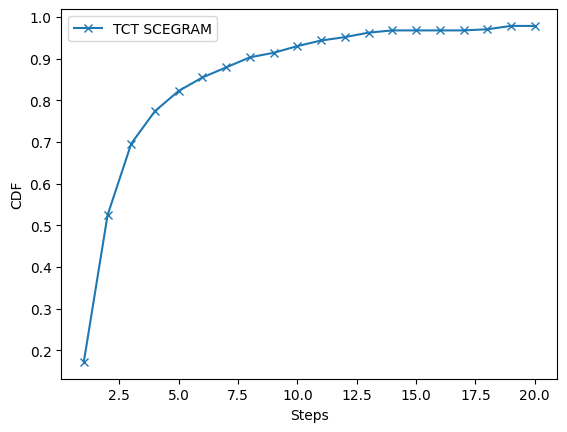

In [13]:
max_steps = 20
paths = tctms
l = 'TCT SCEGRAM'

cdf = get_cdf(paths, max_steps)

plt.plot(np.arange(1, 21), cdf, label=l, marker='x')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('CDF')

In [14]:
cdf_dict['sce_gram'] = cdf